# Симулятор теплопроводности/диффузии 

Данный код моделирует линейную модель диффузии, которая подчиняется уравнению в частных производных вида

$U_t = a U_{xx} + f$

где:
- $a$ — постоянный коэффициент
- $U$ — некоторая физическая величина (температура для теплопроводности, плотность для диффузии и т.п.)
  
несмотря на простоту модели, данная задача уже может указать на большинство проблем, которые могут встретиться при численном моделировании разных параболических систем. 

Для решения уравнения диффузии код использует метод конечного объема/конечных разностей с различными способами аппроксимации задачи по времени — стандартной явной схемой, а также с использованием методов Рунге-Кутты-Лежандра для ускорения расчетов.


In [2]:
'''
#######################################################################################################################
#######################################################################################################################
#  
#  В данном блоке задаются необходимые нам библиотеки.
#  
#######################################################################################################################
#######################################################################################################################
'''

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # добавляем импорт clear_output и display
import time
import sys 

In [3]:
'''
#######################################################################################################################
#######################################################################################################################
# 
#  Для использования метода конечного объема зададим одномерную сетку на призме единичного сечения 
#     +-----+-----+-----+-----+-----+-----+-----+-----+
#    /  1  /     /     /     /     /     /     /     /|
#   /     /     /     /     /     /     /     /     / |
#  +-----+-----+-----+-----+-----+-----+-----+-----+  |
#  | 1   |     |     |     |     |     |     |     |  |
#  |     |     |     |     |     |     |     |     |  +
#  |     |     |     |     |     |     |     |     | /
#  |     |     |     |     |     |     |     |     |/
#  +--dx-+-----+-----+-----+-----+-----+-----+-----+
# 
#######################################################################################################################
#######################################################################################################################
'''

def grid_setup(xmin, xmax, Nx):
    
    #разрешение сетки dx
    dx = (xmax - xmin)/Nx
    #координата центра ячейки (+ 1 фиктивная ячека слева и справа от границы)
    cx = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, Nx + 2, dtype=np.double)
    #координата грани ячейки (+ 1 фиктивная ячека слева и справа от границы)
    fx = np.linspace(xmin - dx, xmax + dx, Nx + 3, dtype=np.double)
    
    return dx, cx, fx

In [4]:
'''
#######################################################################################################################
#######################################################################################################################
#
# зададим решение в начальный момент времени (setup = 'disc' -- начальный профиль с разрывом, 
# setup = 'smooth' -- гладкий начальный профиль)
# 
#######################################################################################################################
#######################################################################################################################
'''
def initial_solution(xmin, xmax, cx, dx, Nx, setup):

    #зададим коэффициент теплопроводности 
    a = 1.0
    
    if setup == 'disc':
        
        #зададим исходные координаты разрыва
        x0_1 = (xmax + xmin)/2.0 - 0.1*(xmax - xmin)
        x0_2 = (xmax + xmin)/2.0 + 0.1*(xmax - xmin)
    
        #задаем массив начальных данных в реальных ячейках
        for i in range(1, Nx + 1):
            if cx[i] < x0_1:
                U0[i] = 1.0
            elif cx[i] < x0_2:
                U0[i] = 2.0
            else:
                U0[i] = 1.0    
                    
    elif setup == 'smooth':
        
        #начальная координата гладкого профиля
        x0 = (xmax + xmin)/2.0
        
        #зададим исходную толщину профиля
        delta = 5.0*dx
    
        #задаем массив начальных данных в реальных ячейках
        for i in range(1, Nx + 1):
            U0[i] = np.exp(-(cx[i] - x0)**2/delta**2)

    else:
        sys.exit("error, choose initial condions from the list in function solution'")
        
        
    #возвращаем решение во время time
    return U0, a

In [5]:
def spatial_operator(U, a, dx):

    LU = a*(U[2:] - 2.0*U[1:-1] + U[:-2])/dx**2

    return LU

# Функция для выполнения одного шага явной схемы
def explicit_step(U0, Nx, dx, a, dt):
    
    #учет граничных условий -- свободная граница
    U0[0] = U0[1]
    U0[Nx+1] = U0[Nx]
        
    U1 = U0.copy()
    
    U1[1:-1] = U0[1:-1] + dt * spatial_operator(U0, a, dx)
    
    return U1

In [6]:
#Коэффициенты для метода RKL2
def rkl2_coefs(s):
    
    w1 = 4.0/(s**2 + s - 2.0)
    
    # Коэффициенты
    b = np.zeros(s+1)
    mu = np.zeros(s+1)
    nu = np.zeros(s+1)
    gamma = np.zeros(s+1)
    b[0] = 1.0/3.0
    b[1] = 1.0/3.0
    for j in range(2, s+1):
        b[j] = (j**2 + j - 2.0)/(2.0*j*(j+1))
        mu[j] = (2.0*j - 1.0)/j * b[j]/b[j-1]
        nu[j] = -(j - 1.0)/j * b[j]/b[j-2]
        gamma[j] = -(1.0 - b[j-1])*mu[j]*w1

    return b, mu, nu, gamma


#один супершаг для метода RKL2
def rkl2_step(U0, Nx, dx, a, dt, b, mu, nu, gamma, s):
    """
    Один супер-шаг по времени для уравнения теплопроводности методом RKL2.
    
    Параметры:
    - U0: массив решения (включая фиктивные ячейки)
    - Nx: число реальных ячеек
    - dx: шаг по пространству
    - dt: шаг по времени, который хотим сделать (супершаг)
    - s: число стадий RKL2
    
    Возвращает:
    - U_new: решение после одного RKL2-супершаг
    """
    
    # Убедимся, что входной массив не изменяется
    U0 = U0.copy()
    
    # Граничные условия (свободные границы)
    U0[0] = U0[1]
    U0[Nx+1] = U0[Nx]
    
    w1 = 4.0/(s**2 + s - 2.0)
        
    # Инициализация
    Y0 = U0.copy()
    Y1 = Y0.copy()
    Y2 = Y1.copy()
    
    LU0 = spatial_operator(U0, a, dx)
    
    # Первая стадия
    Y1[1:-1] = Y0[1:-1] + (w1/3.0) * dt * LU0

    # Следующие стадии
    for j in range(2, s + 1):
        
        # Обновляем граничные условия
        Y1[0] = Y1[1]
        Y1[Nx+1] = Y1[Nx]
        Y2 = Y1.copy()
        
        #обновляем решение 
        Y2[1:-1] = mu[j] * Y1[1:-1] + nu[j] * Y0[1:-1] + w1*mu[j] * dt * spatial_operator(Y1, a, dx) + \
            (1.0 - mu[j] - nu[j]) * U0[1:-1] + gamma[j] * dt * LU0
        
        Y0 = Y1
        Y1 = Y2

    return Y1


In [12]:
'''
#######################################################################################################################
#######################################################################################################################
# 
#   Здесь начинается основной код программы
# 
#######################################################################################################################
#######################################################################################################################
'''
#задаем нашу сетку - координаты границ и число ячеек
xmin = 0.0
xmax = 10.0
Nx = 5000

#задаем сеточные массивы
dx, cx, fx = grid_setup(xmin, xmax, Nx)

#инициализируем массивы решения U0 (текущий шаг по времени) и U1 (следующий шаг по времени), а также точное решение Ua
U0 = np.zeros(Nx + 2, dtype=np.double)
U1 = np.zeros(Nx + 2, dtype=np.double)

#зададим вид начального условия
setup = 'disc'

#зададим начальные условия для времени time = 0, а также финальное время time_fin
U0, a = initial_solution(xmin, xmax, cx, dx, Nx, setup)
phystime_fin = 2.0

Integr = np.sum(U0[1:-1]*dx)
print(Integr)

#задаем начальное время равным нулю
phystime = 0.0
#задаем начальное число шагов
nts = 0

solver = 'rkl2' #'expl' and 'rkl2'
S = 2
b, mu, nu, gamma = rkl2_coefs(S)

tcfl = 0.9*dx**2/(2.0 * a)

#таймер для времени работы программы
start_time = time.time() 

#цикл по времени
while phystime < phystime_fin - 1e-14:
    
    #явная схема
    if (solver == 'expl'):
        dt = min(tcfl, phystime_fin - phystime)
        U1 = explicit_step(U0, Nx, dx, a, dt)

    #RKL2
    elif (solver == 'rkl2'):
        dt = min(phystime_fin - phystime, tcfl*(S**2 + S - 2)/4.0 )  # supertimestepping
        U1 = rkl2_step(U0, Nx, dx, a, dt, b, mu, nu, gamma, S)

    #throw an error
    else:
        sys.exit("error, choose either 'expl' or 'rkl2' solver")
        
    '''перезаписываем наше численное решение для использования на следующем шаге по времени'''
    #(в итоге мы храним только два решения, а не все слои по t)
    U0[1:-1] = U1[1:-1]

    phystime += dt
    nts += 1

#таймер для времени работы программы
end_time = time.time() 
print('elapsed time (s) = ', end_time - start_time)
print('num of timesteps = ', nts)    

12.000000000000002
elapsed time (s) =  55.65256071090698
num of timesteps =  1111112


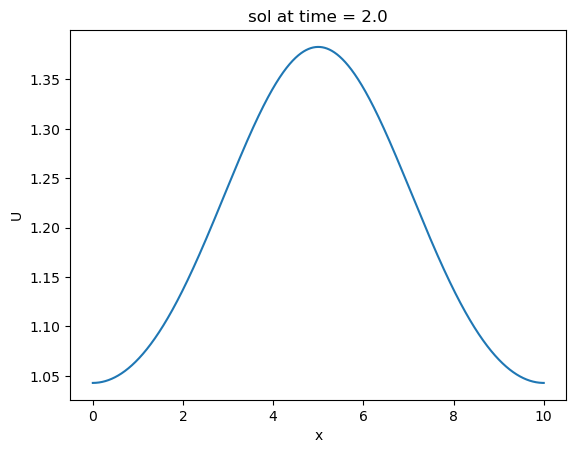

11.999999999999371


In [8]:
#если не работает ipython - можно поставить runtimeplot = 0
runtimeplot = 1
if runtimeplot == 1:
    # Создание фигуры для графика
    fig, ax = plt.subplots()
    line, = ax.plot(cx[1:-1], U0[1:-1])
    ax.set_title('solution at time = ' + str(np.round(phystime, 3)))
    ax.set_xlabel('x')
    ax.set_ylabel('U')
    plt.close()  # Закрываем фигуру, чтобы она не отображалась сразу


line.set_data(cx[1:-1], U1[1:-1])
ax.set_title('sol at time = '+ str(np.round(phystime, 4)))
        
# Автоматическое масштабирование осей
ax.relim()
ax.autoscale_view()
        
#clear_output(wait=True)
# Обновление графика с задержкой
#plt.pause(0.1)
display(fig)
plt.ioff()
plt.show()
Integr = np.sum(U0[1:-1]*dx)
print(Integr)